In [1]:
import os
import natsort
import skimage
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from skimage import io, color
from matplotlib import pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import scipy.misc
from scipy import ndimage
%matplotlib inline 

In [2]:
#Directory
data = 'HPTLCRaw\\'

### Color Import

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(io.imread(data+filename)[:,:,:3])

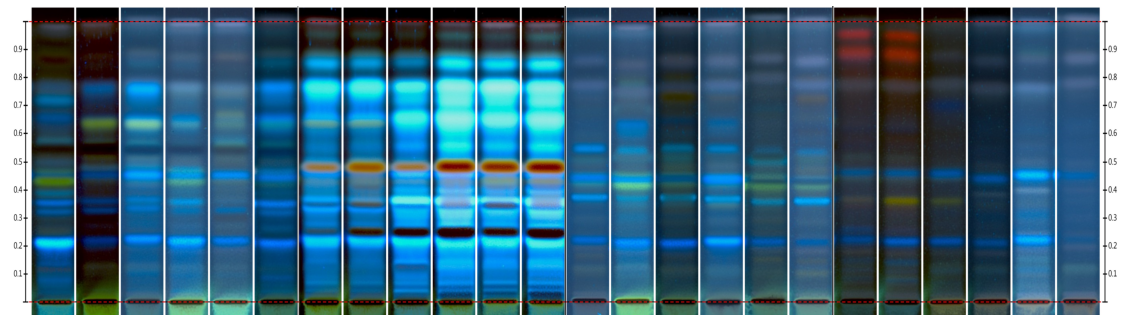

In [4]:
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(image_list[0])

### Grey Scale Import

In [5]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

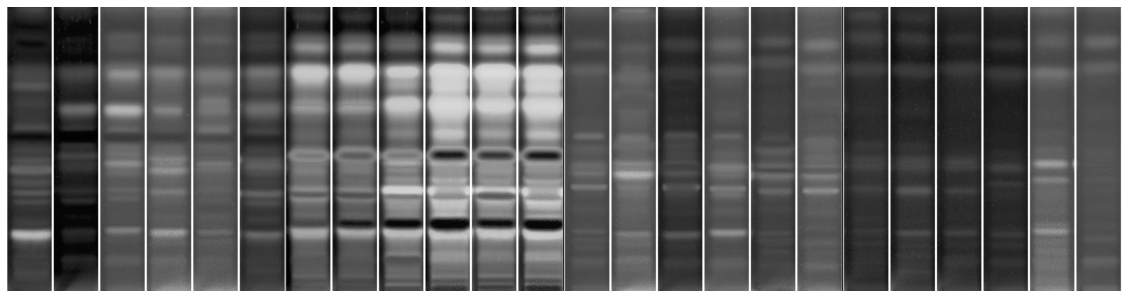

In [6]:
crop_img = image_list[0][70:-71,96:-84]
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(crop_img,cmap='gray') #, interpolation='nearest'

In [7]:
np.shape(crop_img)

(1075, 4220)

### Algorithmically Determining Crop Locations

In [8]:
det_crops = pd.DataFrame(crop_img)
np.shape(det_crops)

(1075, 4220)

##### Determing count of pixels above value .8 in each column

In [9]:
col_hi_cnt = det_crops[det_crops>.8].count()
print(col_hi_cnt.max())
print(col_hi_cnt.min())

1075
0


([], [])

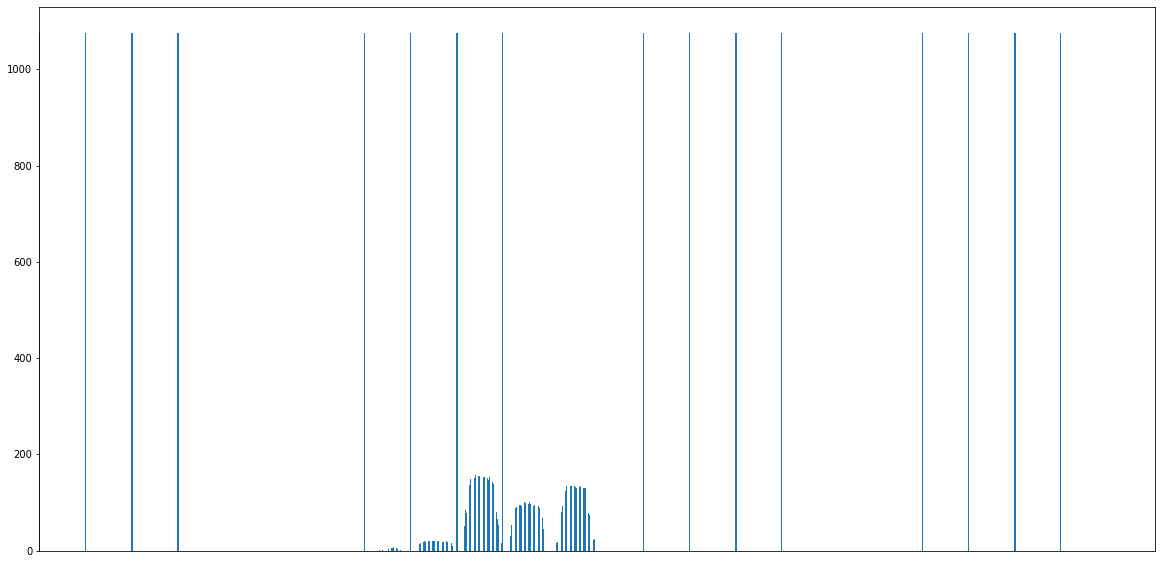

In [10]:
plt.figure(figsize = (20,10))
col_hi_cnt.plot.bar()
plt.xticks([])

([], [])

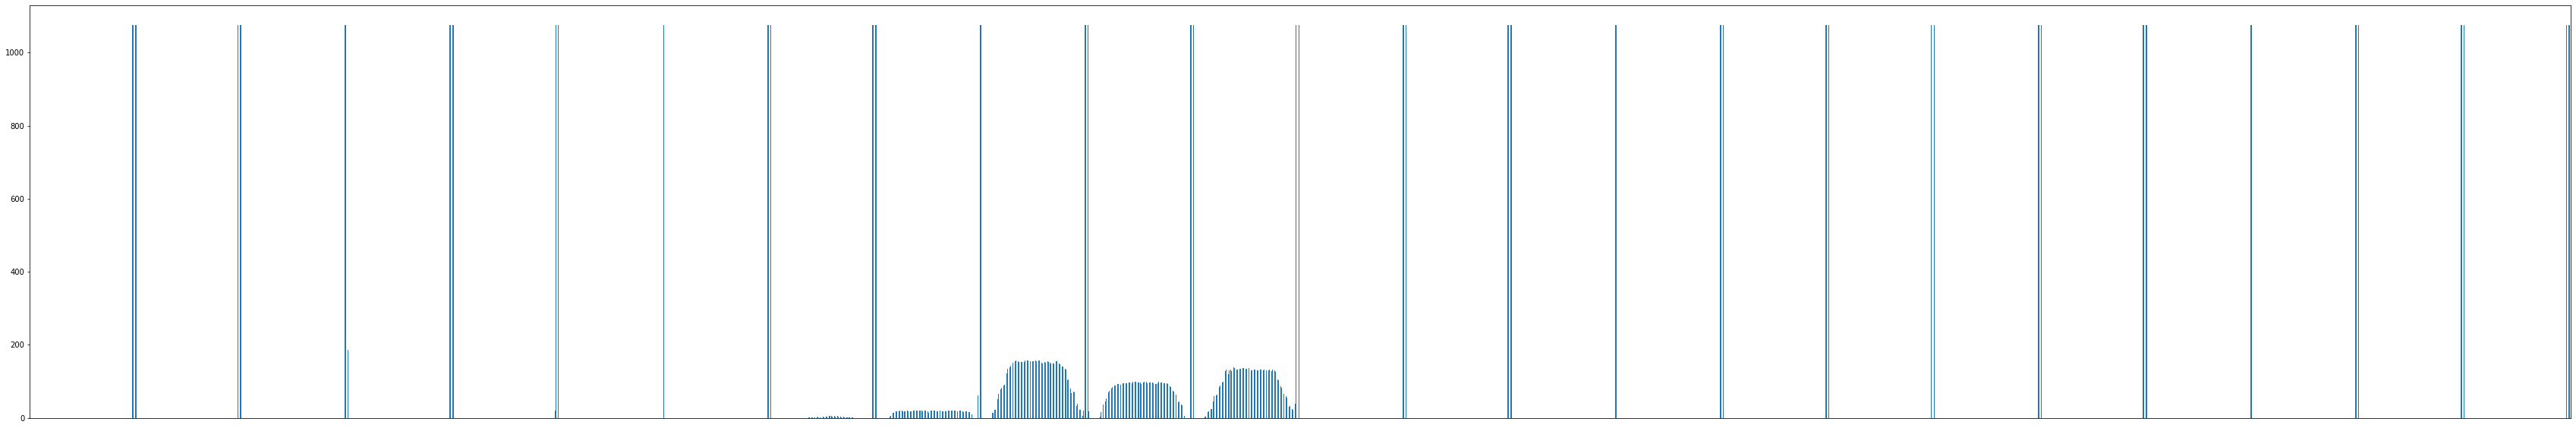

In [11]:
plt.figure(figsize = (60,10))
col_hi_cnt.plot.bar()
plt.xticks([])

### Algorithm to determine crop locations

In [12]:
def det_crop_locations(ar):
    print(len(ar))
    q = []
    q.append([0,0])

    i = 10
    while i < len(ar):
        # While we have not found a back wall, or that wall is not far enough from the previous wall
        # keep looking for a back wall
        while not (ar[i] - ar[i-1] > 550) or not (i - q[-1][0] > 25):
            i += 1

        # Once you find the back wall, add it to the q
        q[-1][1] = i - 15
        
        # While we have not found a front wall, or that wall is not far enough from the previous wall
        # keep looking for a front wall
        while i < len(ar) and (not (ar[i-1] - ar[i] > 550) or not (i - q[-1][1] > 3)):
            i += 1

        #Once you find the fron
        q.append([i + 15,0])

    q.pop()
    return q

In [13]:
crops = det_crop_locations(col_hi_cnt.copy())
print(crops)
print(len(crops))

4220
[[0, 154], [192, 330], [368, 506], [543, 682], [719, 858], [895, 1034], [1065, 1208], [1246, 1384], [1421, 1560], [1597, 1735], [1773, 1911], [1949, 2087], [2118, 2263], [2301, 2439], [2476, 2615], [2652, 2790], [2828, 2966], [3004, 3142], [3173, 3318], [3356, 3494], [3531, 3670], [3707, 3846], [3883, 4021], [4059, 4197]]
24


([], [])

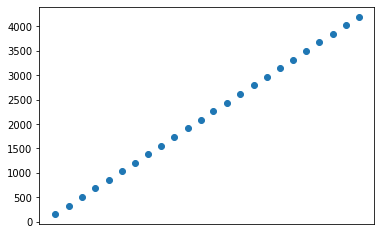

In [14]:
crop_graph = pd.DataFrame(crops)
plt.scatter(x=crop_graph[0],y=crop_graph[1])
plt.xticks([])

##### Cropping Image and adding Individual Slices to new Array

In [15]:
strip_array = []
min_width = float('inf')

#Get Each individual strip & the value of the minimum width
for crop in crops:
    front, back = crop
    min_width = min(min_width,back-front)
    strip_array.append(crop_img[:,front:back])

#Crop each strips width to the minimum width
for i in range(len(strip_array)):
    strip_array[i] = strip_array[i][:,:min_width]
    # print(np.shape(strip_array[i]))

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

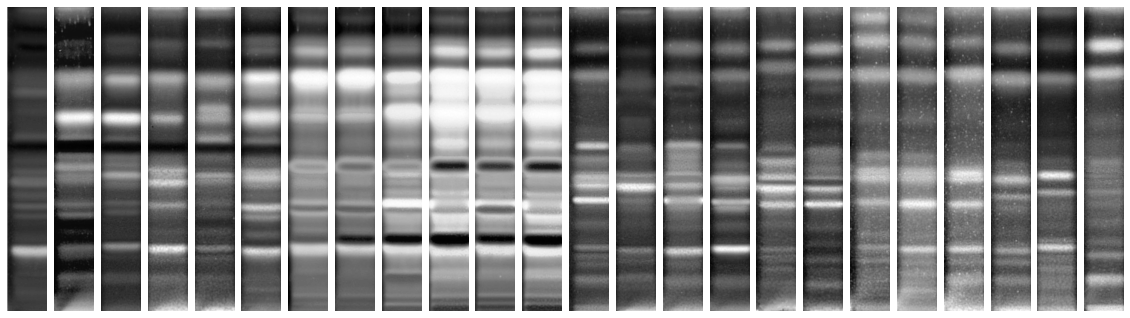

In [16]:
fig = plt.figure(figsize=(20, 10))  # width, height in inches
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray') #, interpolation='nearest'
plt.tight_layout

##### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [17]:
strip_row_avg = []

for i, strip in enumerate(strip_array):
    strip_row_avg.append([])
    for row in strip:
        strip_row_avg[i].append(row.mean())


In [18]:
np.shape(strip_row_avg[0])

(1075,)

In [19]:
np.shape(np.transpose([strip_row_avg[i] for k in range(min_width)]))

(1075, 138)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

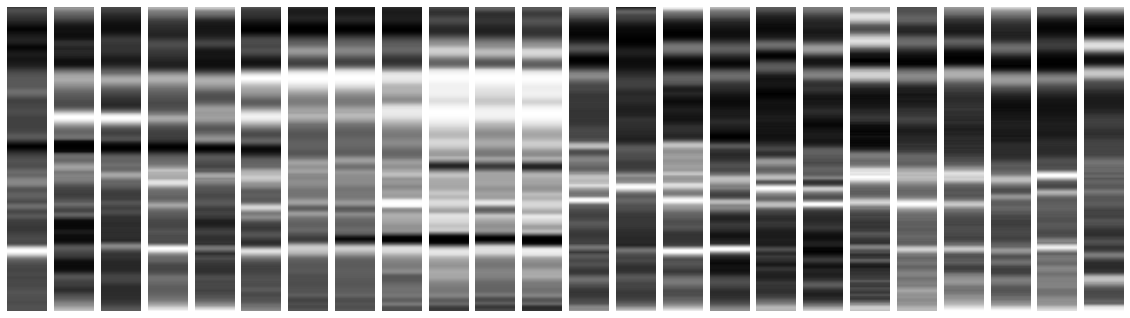

In [20]:
fig = plt.figure(figsize=(20, 10))  # width, height in inches
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [strip_row_avg[i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

In [21]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


##### Append Targets to feature array

In [22]:
for i in range(6):
    strip_row_avg[i].append(1)
for i in range(6,12):
    strip_row_avg[i].append(2)
for i in range(12,18):
    strip_row_avg[i].append(3)
for i in range(18,21):
    strip_row_avg[i].append(4)
for i in range(21,24):
    strip_row_avg[i].append(5)

In [23]:
strip_row_avg = pd.DataFrame(strip_row_avg)

In [24]:
print(strip_row_avg)

        0         1         2         3         4         5         6     \
0   0.180130  0.190611  0.201655  0.210409  0.216723  0.224219  0.231327   
1   0.221292  0.225812  0.228350  0.229753  0.230000  0.228898  0.226384   
2   0.362327  0.359342  0.357143  0.355693  0.354109  0.351736  0.349556   
3   0.479371  0.479893  0.478954  0.478939  0.478373  0.472365  0.464362   
4   0.486626  0.486727  0.484946  0.484735  0.485391  0.477694  0.468610   
5   0.232381  0.230583  0.229749  0.223108  0.218556  0.218010  0.217005   
6   0.242911  0.233880  0.226599  0.221263  0.215504  0.209866  0.204618   
7   0.174738  0.167520  0.161678  0.155533  0.147190  0.140144  0.137344   
8   0.181560  0.177544  0.173854  0.168767  0.162993  0.157907  0.152194   
9   0.255685  0.258301  0.259926  0.259437  0.254807  0.249532  0.245502   
10  0.353123  0.359173  0.363564  0.365368  0.363595  0.359134  0.357347   
11  0.304139  0.313058  0.318002  0.318983  0.320821  0.321719  0.319642   
12  0.370473

##### Get Feature Dataframe

In [26]:
df_feat = strip_row_avg.iloc[:,:-2]
np.shape(df_feat)

(24, 1074)

##### Get Target Dataframe

In [64]:
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()
np.shape(df_target)

(24,)

### Linear SVC Attempt

In [28]:
model = LinearSVC()

In [93]:
model.set_params(random_state=101,verbose=1,max_iter=4500)

LinearSVC(max_iter=4500, random_state=101, verbose=1)

In [94]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 4500,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 101,
 'tol': 0.0001,
 'verbose': 1}

In [89]:
model.fit(df_feat,df_target)

[LibLinear]

LinearSVC(max_iter=4500, random_state=101, verbose=1)

In [73]:
model.score(df_feat,df_target)

1.0

In [92]:
answer = model.predict(np.array(df_feat))
print(answer)

[1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 5 5 5]


### Beyond the basic Linear SVC

In [98]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=101, tol=1e-5,verbose=1,max_iter=4500))

In [99]:
clf.fit(df_feat, df_target)

[LibLinear]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=4500, random_state=101, tol=1e-05,
                           verbose=1))])